## Sentiment Analysis With Basic Neural Network

Using imdb movie reviews dataset, we will train a basic ANN to predict the sentiment of Warren Buffett's annual 'Letter to Shareholders'.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import regex as re
from sklearn.model_selection import train_test_split

# Load IMDB dataset
dataset = tfds.load('imdb_reviews', split='train')
dataframe = tfds.as_dataframe(dataset)

# Decode each text and put into pandas df
imdb_df = pd.DataFrame()
regexes = (("<", ""), ("br", "", ), ("/>", ""), ("  ", " "))
reviews = []
for text in dataframe['text']:
    text = text.decode()
    for reg in regexes:
        text = re.sub(reg[0], reg[1], text)
    reviews.append(text)
imdb_df['text'] = reviews
imdb_df['label'] = dataframe['label']

# Split data into training and validation
train_X, test_X, train_y, test_y = train_test_split(imdb_df['text'].values, imdb_df['label'].values, test_size=0.2)

2023-07-26 18:43:28.692345: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 18:43:28.878513: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 18:43:28.880122: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 18:43:31.405331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ben/.pyenv/versions/3.10.6/envs/BuffettLetters/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-

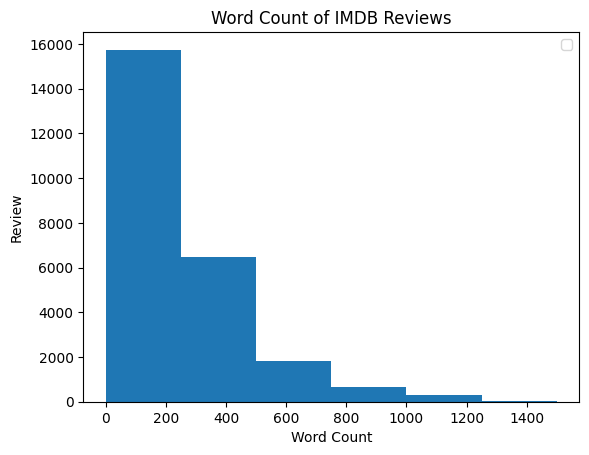

In [2]:
import matplotlib.pyplot as plt
import nltk

# Tokenize each review
tokenized_reviews = []   
for text in imdb_df['text']:
    text = nltk.word_tokenize(text)
    tokenized_reviews.append(text)

# Add to new df
df_tok = pd.DataFrame()
df_tok['text'] = tokenized_reviews

# Plot hist of word counts
fig = plt.figure()
ax = fig.add_subplot()
ax.hist([len(text) for text in df_tok['text']], [0, 250, 500, 750, 1000, 1250, 1500])
ax.set_title('Word Count of IMDB Reviews')
ax.set_xlabel('Word Count')
ax.set_ylabel('Review')
ax.legend()

IMDB reviews are much shorter than the letters we are trying to predict the sentiment of. Therefore, we will train the ANN to predict the sentiment of individual sentences and then use the average sentiment of all sentences in a letter to predict the overall sentiment of the letter.

In [3]:
from keras.layers import TextVectorization

# Parameters for vocab size and number of words in a sequence
vocab_size = 10000
seq_len = 250  # Rough average of word count

# Use TextVectorization to turn strings into vectors of integers
vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size, 
    output_mode='int',
    output_sequence_length=seq_len)

# Build vocabulary
all_reviews = imdb_df['text'].values
vectorize_layer.adapt(all_reviews)

In [4]:
# Build model
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

# Train model
model.fit(train_X, train_y, epochs=30)
history = model.history

Epoch 1/30
625/625 [==============================] - 3s 4ms/step - loss: 0.5757 - accuracy: 0.7427
Epoch 2/30
625/625 [==============================] - 2s 3ms/step - loss: 0.3136 - accuracy: 0.8790
Epoch 3/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2406 - accuracy: 0.9079
Epoch 4/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2005 - accuracy: 0.9246
Epoch 5/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1694 - accuracy: 0.9377
Epoch 6/30
625/625 [==============================] - 2s 4ms/step - loss: 0.1469 - accuracy: 0.9488
Epoch 7/30
625/625 [==============================] - 2s 4ms/step - loss: 0.1267 - accuracy: 0.9581
Epoch 8/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1101 - accuracy: 0.9646
Epoch 9/30
625/625 [==============================] - 2s 3ms/step - loss: 0.0945 - accuracy: 0.9714
Epoch 10/30
625/625 [==============================] - 2s 3ms/step - loss: 0.0825 - accuracy: 0.9759

Text(0, 0.5, 'Loss')

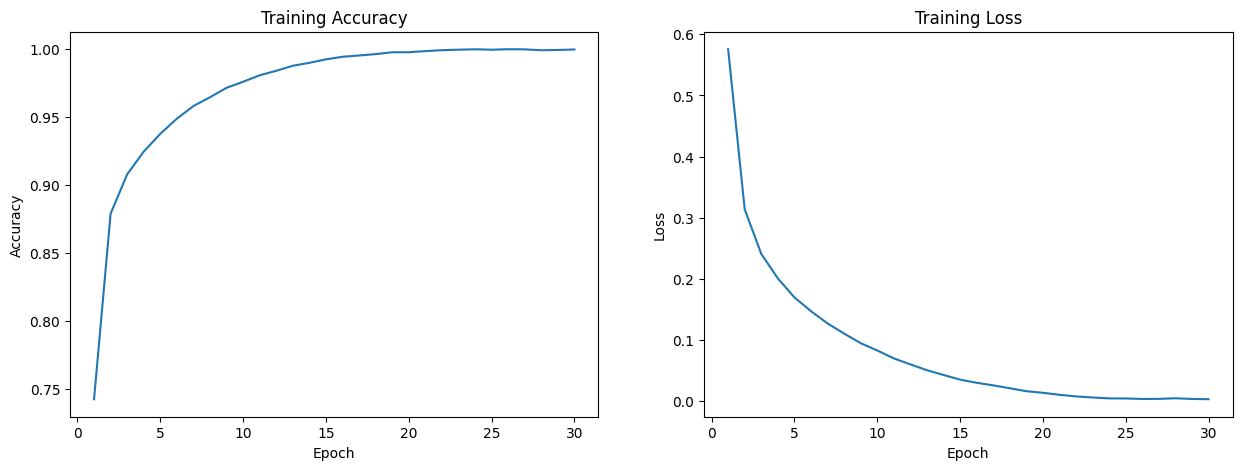

In [5]:
# Graph training accuracy and loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
epochs = [i for i in range(1, len(history.history['loss'])+1)]
axes[0].plot(epochs, history.history['accuracy'], label='traning accuracy')
axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[1].plot(epochs, history.history['loss'], label='loss')
axes[1].set_title('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

In [6]:
# Load buffett letters
letters = []
with open('data/letters.txt', 'r', encoding='utf8') as file:
    for count, line in enumerate(file):

        # Split letter into list of sentences and remove figures
        sents = nltk.sent_tokenize(line)
        for sent in sents:
            if (re.search("\.\.\.\.\.", sent)) is not None:  # Figures indicated by long elipses
                del sents[sents.index(sent)]
            if (re.search("\. \. \. \. ", sent)) is not None:  # 21st letter has spaces inbetween periods
                del sents[sents.index(sent)]
        letters.append(sents)

In [7]:
# Read sp500 data, reverse indices, and start at 1977
sp500 = pd.read_csv('data/sp500.csv')
sp500 = sp500.iloc[::-1]
sp500 = sp500[sp500['year'] >= 1978]
sp500 = sp500.reset_index()

# Load letters and SP500 performance into df
df = pd.DataFrame()
df['Year'] = [i for i in range(1977, 2022)]
df['Letter'] = letters
df['SP500 Year After'] = sp500['performance']
df.head()

,Year,Letter,SP500 Year After
0,1977,[To the Stockholders of Berkshire Hathaway Inc...,6.56
1,1978,[To the Shareholders of Berkshire Hathaway Inc...,18.44
2,1979,[To the Shareholders of Berkshire Hathaway Inc...,32.42
3,1980,[To the Shareholders of Berkshire Hathaway Inc...,-4.91
4,1981,[To the Shareholders of Berkshire Hathaway Inc...,21.55


In [ ]:
# Predict sentiment of each sentence in each letter
sentiments = []
for letter in letters:
    avg_sent = []
    for sent in letter:
        sent = [sent]
        avg_sent.append(model.predict(sent))
    avg_sent = sum(avg_sent) / len(avg_sent)
    sentiments.append(avg_sent)

# Add sentiment to df
df['Sentiment'] = sentiments

# Save df as pickle
df.to_pickle('ann_pred.pkl')

No need to predict every time, it takes over 40 minutes. Results saved as ann_pred.pkl.

In [30]:
# Load df from pickle
df = pd.read_pickle('ann_pred.pkl')

# Extract value from sentiment column
df['Sentiment'] = df['Sentiment'].apply(lambda x: float(x[0][0]))


In [35]:
# Scale SP500 and Sentiment columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['SP500 Year After'] = scaler.fit_transform(df[['SP500 Year After']])
df['Sentiment'] = scaler.fit_transform(df[['Sentiment']])
df.head()

,Year,Letter,SP500 Year After,Sentiment
0,1977,[To the Stockholders of Berkshire Hathaway Inc...,0.584071,0.128410
1,1978,[To the Shareholders of Berkshire Hathaway Inc...,0.743363,0.436595
2,1979,[To the Shareholders of Berkshire Hathaway Inc...,0.930813,0.285983
3,1980,[To the Shareholders of Berkshire Hathaway Inc...,0.430276,0.075540
4,1981,[To the Shareholders of Berkshire Hathaway Inc...,0.785063,0.127439


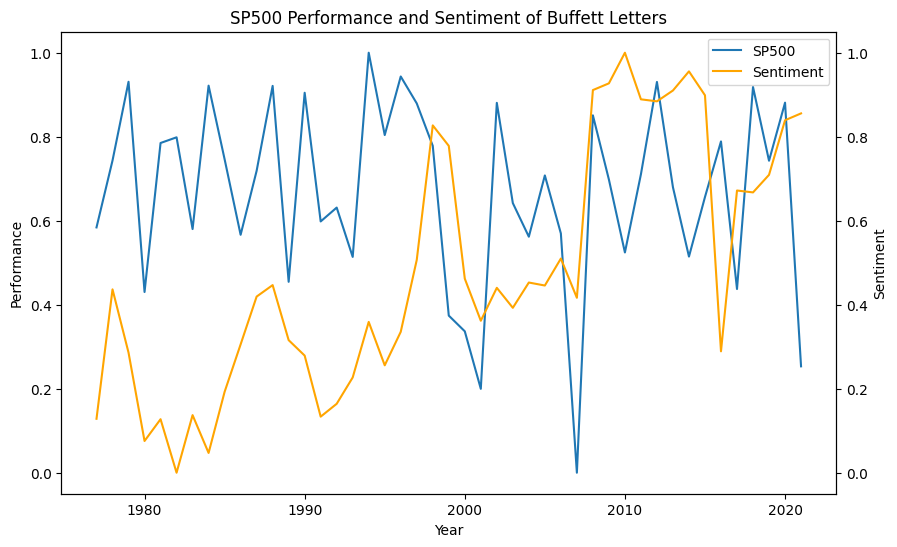

In [37]:
# Plot SP500 performance and sentiment
fig, ax = plt.subplots()
fig.set_figheight(6), fig.set_figwidth(10)
ax.plot(df['Year'], df['SP500 Year After'], label='SP500')
ax.set_title('SP500 Performance and Sentiment of Buffett Letters')
ax.set_xlabel('Year')
ax.set_ylabel('Performance')
ax2 = ax.twinx()
ax2.plot(df['Year'], df['Sentiment'], color='orange', label='Sentiment')
ax2.set_ylabel('Sentiment')

# Add legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

It's not clear there is any correlation between predicted sentiment and SP500 performance the year after a letter was written. Sentiments are often more positive after the late 1990's, not tied to market performance at all, so it's not clear that the basic neural network is learning anything useful.

## Sentiment Analysis With Recurrent Neural Network